In [1]:
!ls ./datasets/kaggle/

2023				  SampleSubmissionStage2.csv
MMasseyOrdinals.csv		  WNCAATourneyCompactResults.csv
MNCAATourneyCompactResults.csv	  WNCAATourneySeeds.csv
MNCAATourneySeeds.csv		  WRegularSeasonCompactResults.csv
MRegularSeasonCompactResults.csv  WTeams.csv
MTeams.csv


In [2]:
!ls ./datasets/torvik/mens/

team_2014.csv  team_2021.csv	    top30_wins_2015.csv  top30_wins_2022.csv
team_2015.csv  team_2022.csv	    top30_wins_2016.csv  top30_wins_2023.csv
team_2016.csv  team_2023.csv	    top30_wins_2017.csv  top30_wins_2024.csv
team_2017.csv  team_2024.csv	    top30_wins_2018.csv  top30_wins_2025.csv
team_2018.csv  team_2025.csv	    top30_wins_2019.csv
team_2019.csv  top30_wins_2014.csv  top30_wins_2021.csv


In [3]:
!ls ./datasets/torvik/womens/

team_2021.csv  team_2024.csv	    top30_wins_2022.csv  top30_wins_2025.csv
team_2022.csv  team_2025.csv	    top30_wins_2023.csv
team_2023.csv  top30_wins_2021.csv  top30_wins_2024.csv


In [4]:
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
teams = {}
teams["M"] = pd.read_csv("./datasets/kaggle/MTeams.csv")
teams["W"] = pd.read_csv("./datasets/kaggle/WTeams.csv")

In [6]:
teams["M"].head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2025
1,1102,Air Force,1985,2025
2,1103,Akron,1985,2025
3,1104,Alabama,1985,2025
4,1105,Alabama A&M,2000,2025


In [7]:
teams["W"].head()

,TeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force
2,3103,Akron
3,3104,Alabama
4,3105,Alabama A&M


In [8]:
MTeamIDToName = {}
MTeamNameToID = {}

for row in range(teams["M"].shape[0]):
    teamID = teams["M"].iloc[row]["TeamID"].item()
    teamName = teams["M"].iloc[row]["TeamName"]
    MTeamIDToName[teamID] = teamName
    MTeamNameToID[teamName] = teamID

In [9]:
WTeamIDToName = {}
WTeamNameToID = {}

for row in range(teams["W"].shape[0]):
    teamID = teams["W"].iloc[row]["TeamID"].item()
    teamName = teams["W"].iloc[row]["TeamName"]
    WTeamIDToName[teamID] = teamName
    WTeamNameToID[teamName] = teamID

In [10]:
m_massey_ordinals = pd.read_csv("./datasets/kaggle/MMasseyOrdinals.csv")
m_massey_ordinals[m_massey_ordinals["SystemName"] == "POM"].tail()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
5540602,2025,128,POM,1476,322
5540603,2025,128,POM,1477,329
5540604,2025,128,POM,1478,354
5540605,2025,128,POM,1479,342
5540606,2025,128,POM,1480,349


In [11]:
m_massey_ordinals[lambda df: df['SystemName'] == "RPI"]['Season'].unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2023, 2024, 2025])

In [12]:
ncaa_regular_season = {}
ncaa_regular_season["M"] = pd.read_csv("./datasets/kaggle/MRegularSeasonCompactResults.csv")
ncaa_regular_season["W"] = pd.read_csv("./datasets/kaggle/WRegularSeasonCompactResults.csv")

In [13]:
ncaa_regular_season["M"][lambda df: df["Season"] == 2024].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
181682,2024,0,1101,64,1329,59,A,0
181683,2024,0,1103,81,1355,75,A,0
181684,2024,0,1104,105,1287,73,H,0
181685,2024,0,1112,122,1288,59,H,0
181686,2024,0,1114,71,1402,66,H,0


In [14]:
ncaa_regular_season["W"][lambda df: df["Season"] == 2024].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
126170,2024,0,3102,65,3176,63,H,0
126171,2024,0,3104,93,3106,39,H,0
126172,2024,0,3107,58,3467,55,A,0
126173,2024,0,3110,81,3255,68,H,0
126174,2024,0,3111,71,3422,65,H,0


In [15]:
ncaa_tourney_compact = {}
ncaa_tourney_compact["M"] = pd.read_csv("./datasets/kaggle/MNCAATourneyCompactResults.csv")
ncaa_tourney_compact["W"] = pd.read_csv("./datasets/kaggle/WNCAATourneyCompactResults.csv")

In [16]:
ncaa_tourney_compact["M"][lambda df: df["Season"] == 2024].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2451,2024,134,1161,67,1438,42,N,0
2452,2024,134,1447,71,1224,68,N,0
2453,2024,135,1160,60,1129,53,N,0
2454,2024,135,1212,88,1286,81,N,0
2455,2024,136,1112,85,1253,65,N,0


In [17]:
ncaa_tourney_compact["W"][lambda df: df["Season"] == 2024].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1583,2024,135,3342,49,3357,42,N,0
1584,2024,135,3435,72,3162,68,N,0
1585,2024,136,3112,69,3120,59,N,0
1586,2024,136,3221,72,3404,45,N,0
1587,2024,137,3104,82,3199,74,N,0


In [18]:
ncaa_tourney_seeds = {}
ncaa_tourney_seeds["M"] = pd.read_csv("./datasets/kaggle/MNCAATourneySeeds.csv")
ncaa_tourney_seeds["W"] = pd.read_csv("./datasets/kaggle/WNCAATourneySeeds.csv")

In [19]:
ncaa_tourney_seeds["M"][lambda df: df["Season"] == 2024].head()

,Season,Seed,TeamID
2490,2024,W01,1163
2491,2024,W02,1235
2492,2024,W03,1228
2493,2024,W04,1120
2494,2024,W05,1361


In [20]:
ncaa_tourney_seeds["W"][lambda df: df["Season"] == 2024].head()

,Season,Seed,TeamID
1608,2024,W01,3376
1609,2024,W02,3323
1610,2024,W03,3333
1611,2024,W04,3231
1612,2024,W05,3328


# Join Datasets

In [21]:
# Iterate through all Torvik team names, and check if it exists in the Kaggle Teams dataset.
# If no match exists, find the match and populate the conversion map.
# After some thinking, I realize it's more efficient to check the names of teams in the tournament, not all D1 schools.

# torvikToKaggleTeamName = {
#     "Arkansas Pine Bluff": "Ark Pine Bluff",
#     "Central Michigan": "C Michigan",
#     "FIU": "Florida Intl",
#     "Illinois Chicago": "IL Chicago",
#     "Florida Atlantic": "FL Atlantic",
#     "Cal St. Northridge": "CS Northridge",
#     "Abilene Christian": "Abilene Chr",
#     "UMKC": "Missouri KC",
#     "Northern Illinois": "N Illinois",
#     "Kent St": "Kent",
#     "Central Arkansas": "Cent Arkansas",
#     "American": "American Univ",
#     "UTSA": "UT San Antonio",
#     "Prairie View A&M": "Prairie View",
#     "Georgia Southern": "Ga Southern",
#     "Tennessee Martin": "TN Martin",
#     "LIU": "LIU Brooklyn",
#     "Loyola Chicago": "Loyola-Chicago",
#     "Maryland Eastern Shore": "MD E Shore",
#     "Fairleigh Dickinson": "F Dickinson",
#     "Queens": "Queens NC",
#     "Nebraska Omaha": "NE Omaha",
# }

# Make sure we can match Torvik teams names with the Kaggle dataset team names
kaggleToTorvikTeamNames = {
    "FL Atlantic": "Florida Atlantic",
    "St Mary's CA": "Saint Mary's",
    "Col Charleston": "Charleston",
    "S Dakota St": "South Dakota St.",
    "Grambling": "Grambling St.",
    "NC State": "N.C. State",
    "WKU": "Western Kentucky",
    "F Dickinson": "Fairleigh Dickinson",
    "TAM C. Christi": "Texas A&M Corpus Chris",
    "Kent": "Kent St.",
    "Kennesaw": "Kennesaw St.",
    "CS Fullerton": "Cal St. Fullerton",
    "TX Southern": "Texas Southern",
    "Loyola-Chicago": "Loyola Chicago",
    "SF Austin": "Stephen F. Austin",
    "N Dakota St": "North Dakota St.",
    "Abilene Chr": "Abilene Christian",
    "FGCU": "Florida Gulf Coast",
    "Ark Little Rock": "Little Rock",
    "MTSU": "Middle Tennessee",
    "St Joseph's PA": "Saint Joseph's",
    "WI Green Bay": "Green Bay",
    "CS Bakersfield": "Cal St. Bakersfield",
    "ETSU": "East Tennessee St.",
    "Mt St Mary's": "Mount St. Mary's",
    "SUNY Albany": "Albany",
    "Coastal Car": "Coastal Carolina",
    "G Washington": "George Washington",
    "WI Milwaukee": "Milwaukee",
    "W Michigan": "Western Michigan",
    "American Univ": "American",
    "C Michigan": "Central Michigan",
    "IUPUI": "IU Indy",
    "CS Sacramento": "Sacramento St.",
    "SE Louisiana": "Southeastern Louisiana",
    "Southern Univ": "Southern",
    "LIU Brooklyn": "LIU",
    "Prairie View": "Prairie View A&M",
    "SE Missouri St": "Southeast Missouri St.",
    "Monmouth NJ": "Monmouth",
    "TN Martin": "Tennessee Martin",
    "SIUE": "SIU Edwardsville",
    "St Francis PA": "Saint Francis",
    "NE Omaha": "Nebraska Omaha",
}

def preprocess_torvik_dataframe(year, torvik_df, kaggle_teamNames_round_64, gender):
    torvik_teams = torvik_df["TeamName"]
    matches_torvik_teamName = lambda kaggle_teamName: ((torvik_teams == kaggle_teamName).sum().item() == 1)
    
    def mutate_torvik_teamName(old, new):
        torvik_df.loc[torvik_df["TeamName"] == old, "TeamName"] = new
        assert torvik_df.loc[torvik_df["TeamName"] == new].shape[0] == 1
    
    for kaggle_teamName in kaggle_teamNames_round_64:
        if matches_torvik_teamName(kaggle_teamName):
            continue
            
        if kaggle_teamName.startswith("St "):
            test_teamNames = [
                "Saint" + kaggle_teamName[kaggle_teamName.index("St") + len("St"):],
                "St." + kaggle_teamName[kaggle_teamName.index("St") + len("St"):],
            ]
            matched = False
            for test_teamName in test_teamNames:
                if matches_torvik_teamName(test_teamName):
                    print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                    mutate_torvik_teamName(test_teamName, kaggle_teamName)
                    matched = True
                    break
                    
            if matched:
                continue
                
        if kaggle_teamName.endswith("St"):
            # Looks like Kaggle uses St, while Torvik uses St.
            # We'll just remove the period at the end
            test_teamName = kaggle_teamName + "."
            if matches_torvik_teamName(test_teamName):
                print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                mutate_torvik_teamName(test_teamName, kaggle_teamName)
                continue

        if kaggle_teamName.startswith("NC "):
            test_teamName = "North Carolina" + kaggle_teamName[kaggle_teamName.index("NC") + len("NC"):]
            if matches_torvik_teamName(test_teamName):
                print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                mutate_torvik_teamName(test_teamName, kaggle_teamName)
                continue
                
        if kaggle_teamName.startswith("S "):
            # Looks like Kaggle uses S, while Torvik uses South
            test_teamName = "South" + kaggle_teamName[kaggle_teamName.index("S") + len("S"):]
            if matches_torvik_teamName(test_teamName):
                print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                mutate_torvik_teamName(test_teamName, kaggle_teamName)
                continue

        if kaggle_teamName.startswith("N "):
            # Looks like Kaggle uses S, while Torvik uses South
            test_teamNames = [
                "North" + kaggle_teamName[kaggle_teamName.index("N") + len("N"):],
                "Northern" + kaggle_teamName[kaggle_teamName.index("N") + len("N"):],
            ]
            matched = False
            for test_teamName in test_teamNames:
                if matches_torvik_teamName(test_teamName):
                    print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                    mutate_torvik_teamName(test_teamName, kaggle_teamName)
                    matched = True
                    break

            if matched:
                continue

        if kaggle_teamName.startswith("E "):
            # Looks like Kaggle uses S, while Torvik uses South
            test_teamName = "Eastern" + kaggle_teamName[kaggle_teamName.index("E") + len("E"):]
            if matches_torvik_teamName(test_teamName):
                print(f"Mutating Torvik dataframe team name from '{test_teamName}' -> '{kaggle_teamName}'")
                mutate_torvik_teamName(test_teamName, kaggle_teamName)
                continue

        if kaggle_teamName in kaggleToTorvikTeamNames:
            print(f"Manual override for '{kaggleToTorvikTeamNames[kaggle_teamName]}' -> '{kaggle_teamName}'")
            torvik_team = torvik_teams[torvik_teams == kaggleToTorvikTeamNames[kaggle_teamName]]
            if torvik_team.shape[0] != 1:
                raise Exception(f"Expected matching Torvik team name in dataframe as dictionary is populated with key {kaggle_teamName}")
            mutate_torvik_teamName(kaggleToTorvikTeamNames[kaggle_teamName], kaggle_teamName)
            continue
        
        similar = torvik_teams[torvik_teams.str.startswith(kaggle_teamName[0])]
        raise Exception(f"No team name conversion found for Kaggle team name '{kaggle_teamName}' in year {year}, gender {gender}\nThe following are Torvik team names that start with the same character\n{similar}")

    return torvik_df

In [22]:
def get_torvik_data_by_year(year, kaggle_teamNames_round_64, gender):
    assert gender == "M" or gender == "W"
    input_dir = f"./datasets/torvik/{"mens" if gender == "M" else "womens"}"
    torvik_team = pd.read_csv(f"{input_dir}/team_{year}.csv")
    torvik_team = torvik_team.dropna(axis=1, how="all")
    
    # Add a winning percentage column
    torvik_team["WinPercentage"] = 100.0 * torvik_team["Wins"] / torvik_team["Games Played"]

     # Add a top 30 wins column
    torvik_top30_wins = pd.read_csv(f"{input_dir}/top30_wins_{year}.csv")
    torvik_top30_wins = torvik_top30_wins.dropna(axis=1, how="all")
    torvik_top30_wins.rename(columns={"Wins": "Top30Wins"}, inplace=True)
    torvik_team = torvik_team.merge(torvik_top30_wins[["TeamName", "Top30Wins"]], how="left", on="TeamName")
    
    torvik_team.fillna({"Top30Wins": 0}, inplace=True) # teams that have zero games played against top 30 do not appear in the top 30 dataset

    return preprocess_torvik_dataframe(year, torvik_team, kaggle_teamNames_round_64, gender)

In [23]:
# For each year Y: 
# For each team T that played in the tournament in year Y (ignore teams eliminated in play-in round):
# Record the number of wins by team T in the tournament in year Y, and collect the covariates for OLRE model

# Covariates:
# winning percentage at the end of the regular season (WINPCT), get this from Torvik instead of Kaggle
# point differential at the end of the regular season (DIFF)
# wins above bubble (WAB)
# number of wins against teams rated in the Top 30 based on Torvik's ratings at the end of the regular season (TOP30WIN)

def get_dataframe_by_year(year, gender):
    assert gender == "M" or gender == "W"
    tourney_seeds = ncaa_tourney_seeds[gender][lambda df: df["Season"] == year].reset_index(drop=True)
    tourney_compact = ncaa_tourney_compact[gender][lambda df: df["Season"] == year].reset_index(drop=True)
    pom_rank = m_massey_ordinals[lambda df: (df["Season"] == year) & (df["SystemName"] == "POM")]
    
    teamIDs_in_tournament = []
    teamNames_in_tournament = []
    
    for i in range(tourney_seeds.shape[0]):
        teamID = tourney_seeds.at[i, "TeamID"]
        seed = tourney_seeds.at[i, "Seed"]
        # if len(seed) > 3:
        #     # Team competed in the play-in round, check if they made it past this round
        #     team_tournament_games_won = tourney_compact[lambda df: df["WTeamID"] == teamID]
        #     if team_tournament_games_won.shape[0] == 0:
        #         # this means the play-in team won zero games (i.e. didn't make it past play-in round)
        #         continue
                
        teamIDs_in_tournament.append(teamID)
        teamNames_in_tournament.append(teams[gender][lambda df: df["TeamID"] == teamID].iloc[0]["TeamName"])
    
    if len(teamIDs_in_tournament) != 68 and len(teamIDs_in_tournament) != 64:
        raise Exception(f"Expected 68 or 64 team IDs, found {len(teamIDs_in_tournament)}")
    if len(teamNames_in_tournament) != 68 and len(teamIDs_in_tournament) != 64:
        raise Exception(f"Expected 68 or 64 team names, found {len(teamNames_in_tournament)}")
    
    # For each of these 64 teams, compute how many games they won in the tournament (ignoring play-in games)
    n_tournament_games_won = []
    for teamID in teamIDs_in_tournament:
        # Tournament games won
        team_tournament_games_won = tourney_compact[lambda df: df["WTeamID"] == teamID]
        seed = tourney_seeds[lambda df: df["TeamID"] == teamID].iloc[0]["Seed"]
        n_games_won = team_tournament_games_won.shape[0]
        
        if len(seed) > 3 and n_games_won > 0:
            n_games_won -= 1
        if gender == "M" and year == 2021 and teamID == MTeamNameToID["Oregon"]:
            n_games_won += 1 # COVID forfeit by VCU in first round
        
        n_tournament_games_won.append(n_games_won)
    
    n_tournament_games_won = np.array(n_tournament_games_won, dtype=np.uint8)
    
    if year < 2025 and n_tournament_games_won.sum() != 32 + 16 + 8 + 4 + 2 + 1:
        raise Exception(f"Expected total of {32 + 16 + 8 + 4 + 2 + 1} games won across all teams in the tournament, found {n_tournament_games_won.sum()}")
    
    # For each of these 64 teams, compute point differential winning percentage
    regular_season_point_differential = []
    for teamID in teamIDs_in_tournament:
        w_games = ncaa_regular_season[gender][lambda df: (df["Season"] == year) & (df["WTeamID"] == teamID)]
        l_games = ncaa_regular_season[gender][lambda df: (df["Season"] == year) & (df["LTeamID"] == teamID)]
        total_point_differential = (w_games["WScore"] - w_games["LScore"]).sum() + (l_games["LScore"] - l_games["WScore"]).sum()
        regular_season_point_differential.append(int(total_point_differential))

    # For each of these 64 teams, get the KenPom ordinal ranking
    # Only available for mens
    ken_pom_ordinal_rank = []
    for teamID in teamIDs_in_tournament:
        try:
            rank = 0 if gender == "W" else pom_rank[lambda df: df["TeamID"] == teamID].iloc[-1]["OrdinalRank"]
            rank = (rank - 1) // 4 + 1
            ken_pom_ordinal_rank.append(rank)
        except Exception as e:
            print(f"Error fetching KenPom ordinal rank for {gender}{year} teamID={teamID} with team name '{MTeamIDToName[teamID]}'")
            print(e)
            exit(1)

    kaggle_df = pd.DataFrame({
        "TeamID": pd.Series(teamIDs_in_tournament),
        "TeamName": pd.Series(teamNames_in_tournament),
        "Tournament Wins": pd.Series(n_tournament_games_won),
        "PointDIFF": pd.Series(regular_season_point_differential),
        "PomOrdinalRank": pd.Series(ken_pom_ordinal_rank)
    })

    torvik_df = get_torvik_data_by_year(year, teamNames_in_tournament, gender)
    Xy = torvik_df.merge(kaggle_df, on="TeamName", how="right")
    Xy["3P%ODDIFF"] = Xy["3P%"] * Xy["3PR"] - Xy["3P%D"] * Xy["3PRD"]

    Xy.to_csv(f"./datasets/Xy_all_{gender}_{year}.csv", index=False)
    
    if Xy.shape[0] != 68 and Xy.shape[0] != 64:
        raise Exception(f"Expected 68 or 64 rows in dataframe (one for each team). Found {Xy.shape[0]} rows.")
    
    Xy_OLRE = Xy[["TeamName", "Tournament Wins", "WinPercentage", "PointDIFF", "WAB", "Top30Wins"]]
    
    if Xy_OLRE.shape[0] != 68 and Xy_OLRE.shape[0] != 64:
        raise Exception(f"Expected 68 rows in dataframe (one for each team). Found {Xy_OLRE.shape[0]} rows.")

    if Xy_OLRE.isna().sum().sum() != 0:
        raise Exception("Detected NaN in dataframe")

    Xy_OLRE.to_csv(f"./datasets/Xy_OLRE_{gender}_{year}.csv", index=False)

    regressors = ["TeamName", "ADJOE", "ADJDE", "BARTHAG", "EFG%", "EFGD%", "FTR", "FTRD", "TOR", "TORD", "ORB", "DRB", "2P%", "2P%D", "3P%", "3P%D", "3P%ODDIFF", "3PR", "3PRD", "ADJ T.", "Top30Wins", "PomOrdinalRank"]
    Xy_train = []
    
    # Build the training data for the logistic regression model
    if year == 2025 or year == 2023:
        X_test = []
        for i in range(len(teamIDs_in_tournament)):
            for j in range(i+1, len(teamIDs_in_tournament)):
                teamID_0 = teamIDs_in_tournament[i]
                teamID_1 = teamIDs_in_tournament[j]
                team_0 = Xy[Xy["TeamID"] == teamID_0][regressors]
                team_1 = Xy[Xy["TeamID"] == teamID_1][regressors]

                if teamID_0 > teamID_1:
                    teamID_0, teamID_1 = teamID_1, teamID_0
                    team_0, team_1 = team_1, team_0
                
                X_test.append(
                    pd.concat([
                        pd.Series({"TeamID_0": teamID_0, "TeamID_1": teamID_1}),
                        team_0.iloc[0].rename(index={ regressor: f"0_{regressor}" for regressor in regressors}),
                        team_1.iloc[0].rename(index={ regressor: f"1_{regressor}" for regressor in regressors}),
                    ])
                )
        X_test = pd.DataFrame(X_test)
        X_test.to_csv(f"./datasets/X_test_{gender}_{year}.csv", index=False)

    if year != 2025:
        Xy_train = []
        for i in range(tourney_compact.shape[0]):
            WTeamID = tourney_compact.at[i, "WTeamID"]
            LTeamID = tourney_compact.at[i, "LTeamID"]
    
            if Xy[Xy["TeamID"] == WTeamID].shape[0] == 0 or Xy[Xy["TeamID"] == LTeamID].shape[0] == 0:
                # At least one of these teams are not in the round of 64 (i.e. eliminated in play-in)
                continue
                
            WTeam = Xy[Xy["TeamID"] == WTeamID][regressors]
            LTeam = Xy[Xy["TeamID"] == LTeamID][regressors]
    
            WTeamProb = 1.0
            
            Xy_train.append(
                pd.concat([
                    pd.Series({"0_ProbWin": WTeamProb, "TeamID_0": WTeamID, "TeamID_1": LTeamID}),
                    WTeam.iloc[0].rename(index={ regressor: f"0_{regressor}" for regressor in regressors}),
                    LTeam.iloc[0].rename(index={ regressor: f"1_{regressor}" for regressor in regressors}),
                ])
            )
    
            # Reverse order to eliminate bias
            Xy_train.append(
                pd.concat([
                    pd.Series({"0_ProbWin": 1.0 - WTeamProb, "TeamID_0": LTeamID, "TeamID_1": WTeamID}),
                    LTeam.iloc[0].rename(index={ regressor: f"0_{regressor}" for regressor in regressors}),
                    WTeam.iloc[0].rename(index={ regressor: f"1_{regressor}" for regressor in regressors}),
                ])
            )
    
        Xy_train = pd.DataFrame(Xy_train)
        Xy_train.to_csv(f"./datasets/Xy_WinProb_{gender}_{year}.csv", index=False)
    else:
        Xy_train = []
        for i in range(len(teamIDs_in_tournament)):
            for j in range(i+1, len(teamIDs_in_tournament)):
                teamID_0 = teamIDs_in_tournament[i]
                teamID_1 = teamIDs_in_tournament[j]
                team_0 = Xy[Xy["TeamID"] == teamID_0][regressors]
                team_1 = Xy[Xy["TeamID"] == teamID_1][regressors]

                if teamID_0 > teamID_1:
                    teamID_0, teamID_1 = teamID_1, teamID_0
                    team_0, team_1 = team_1, team_0
                          
                Xy_train.append(
                    pd.concat([
                        pd.Series({"0_ProbWin": 0.5, "TeamID_0": teamID_0, "TeamID_1": teamID_1}),
                        team_0.iloc[0].rename(index={ regressor: f"0_{regressor}" for regressor in regressors}),
                        team_1.iloc[0].rename(index={ regressor: f"1_{regressor}" for regressor in regressors}),
                    ])
                )

        Xy_train = pd.DataFrame(Xy_train)
        Xy_train.to_csv(f"./datasets/Xy_WinProb_{gender}_{year}.csv", index=False)
        
    return Xy_OLRE, Xy_train

In [24]:
M_years = [2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024, 2025] # skip 2020
W_years = [2021, 2022, 2023, 2024, 2025]

# M_years, W_years = [2025], [2025]

for year in M_years:
    get_dataframe_by_year(year, "M")

for year in W_years:
    get_dataframe_by_year(year, "W")

Mutating Torvik dataframe team name from 'Iowa St.' -> 'Iowa St'
Mutating Torvik dataframe team name from 'Michigan St.' -> 'Michigan St'
Manual override for 'George Washington' -> 'G Washington'
Manual override for 'Saint Joseph's' -> 'St Joseph's PA'
Mutating Torvik dataframe team name from 'North Carolina Central' -> 'NC Central'
Manual override for 'Milwaukee' -> 'WI Milwaukee'
Manual override for 'Coastal Carolina' -> 'Coastal Car'
Mutating Torvik dataframe team name from 'Ohio St.' -> 'Ohio St'
Manual override for 'Stephen F. Austin' -> 'SF Austin'
Manual override for 'Western Michigan' -> 'W Michigan'
Mutating Torvik dataframe team name from 'Eastern Kentucky' -> 'E Kentucky'
Manual override for 'Albany' -> 'SUNY Albany'
Manual override for 'Mount St. Mary's' -> 'Mt St Mary's'
Mutating Torvik dataframe team name from 'Wichita St.' -> 'Wichita St'
Mutating Torvik dataframe team name from 'Saint Louis' -> 'St Louis'
Mutating Torvik dataframe team name from 'Kansas St.' -> 'Kansas 

In [25]:
team_name = "LIU Brooklyn"
year = 2018
ncaa_tourney_seeds['M'][lambda df: (df['Season'] == year) & (df['TeamID'] == MTeamNameToID[team_name])]

,Season,Seed,TeamID
2166,2018,W16a,1254


# Plotting Histograms

In [26]:
import matplotlib.pyplot as plt

In [27]:
def plot_by_year(year, gender):
    assert gender == "M" or gender == "W"
    Xy_OLRE, _ = get_dataframe_by_year(year, gender)
    
    fig, ax = plt.subplots()
    ax.hist(Xy_OLRE["Tournament Wins"])
    ax.set_title(f"Distribution of {gender}{year} Tournament Wins")
    ax.set_ylabel("Number of Teams")
    ax.set_xlabel("Number of Tournament Wins")
    fig.savefig(f"./images/distribution-{gender}-{year}-tournament-wins.png")

    fig, ax = plt.subplots()
    ax.hist(Xy_OLRE["WinPercentage"], bins=10)
    ax.set_title(f"Distribution of Win Percentage By Teams in {gender}{year} Tournament")
    ax.set_ylabel("Number of Teams")
    ax.set_xlabel("Win %")
    fig.savefig(f"./images/distribution-{gender}-{year}-win-percentage.png")

    pointDiff_min, pointDiff_max = int(Xy_OLRE["PointDIFF"].min()), int(Xy_OLRE["PointDIFF"].max())
    fig, ax = plt.subplots()

    ax.hist(Xy_OLRE["PointDIFF"].to_numpy(), bins=10)
    ax.set_title(f"Distribution of Regular Season Point Differential By Teams in {gender}{year} Tournament")
    ax.set_ylabel("Number of Teams")
    ax.set_xlabel("Point Differentials")
    fig.savefig(f"./images/distribution-{gender}-{year}-point-differentials.png")

    fig, ax = plt.subplots()
    ax.hist(Xy_OLRE["WAB"])
    ax.set_title(f"Distribution of Wins Above Bubble By Teams in {gender}{year} Tournament")
    ax.set_ylabel("Number of Teams")
    ax.set_xlabel("Wins Above Bubble")
    fig.savefig(f"./images/distribution-{gender}-{year}-wins-above-bubble.png")

    fig, ax = plt.subplots()
    ax.hist(Xy_OLRE["Top30Wins"])
    ax.set_title(f"Distribution of Wins Against Top 30 Teams By Teams in {gender}{year} Tournament")
    ax.set_ylabel("Number of Teams")
    ax.set_xlabel("Top 30 Wins")
    fig.savefig(f"./images/distribution-{gender}-{year}-top-30-wins.png")

In [28]:
# plot_by_year(2024, "M")

# Finalize Prediction File

We use R to fit the data. We only predict the probability for matchups between teams in the tournament. We need to add the matchups with teams not in the tournament. Use the stage 2 submission file.

In [56]:
R_mens_pred = pd.read_csv("./prediction/2025-tourney-team-M-predictions.csv")
R_womens_pred = pd.read_csv("./prediction/2025-tourney-team-W-predictions.csv")
R_pred = pd.concat([R_mens_pred, R_womens_pred])
sample_submission_stage_2 = pd.read_csv("./datasets/kaggle/SampleSubmissionStage2.csv")

In [57]:
sample_submission_stage_2.columns

Index(['ID', 'Pred'], dtype='object')

In [58]:
def log_reg_predict_2025():
    ID_column = []
    pred_column = []
    
    for i in range(sample_submission_stage_2.shape[0]):
        ID = sample_submission_stage_2.at[i, "ID"]
        [teamID_i, teamID_j] = list(map(int, sample_submission_stage_2.at[i, "ID"].split("_")[-2:]))
        
        assert teamID_i < teamID_j
            
        rows = R_pred[lambda df: (df["TeamID_0"] == teamID_i) & (df["TeamID_1"] == teamID_j)]
        
        assert rows.shape[0] <= 1

        ID_column.append(ID)
        
        if rows.shape[0] == 0:
            pred_column.append(0.5)
        else:
            pred_column.append(rows.iloc[0]['pred_prob'])
    
    pred_df = pd.DataFrame({"ID": ID_column, "pred": pred_column})
    return pred_df

## Prediction file

In [59]:
pred = log_reg_predict_2025()

In [60]:
pred[lambda df: df["pred"] != 0.5].shape

(4556, 2)

In [61]:
assert pred[lambda df: df["pred"] != 0.5].shape[0] == 68 * 67

In [62]:
pred.to_csv("./prediction/2025-logistic-regression-prediction.csv", index=False)

## 2023 Back Test

In [36]:
R_mens_pred_2023 = pd.read_csv("./prediction/2023-tourney-team-M-predictions.csv")
R_womens_pred_2023 = pd.read_csv("./prediction/2023-tourney-team-W-predictions.csv")
R_pred_2023 = pd.concat([R_mens_pred_2023, R_womens_pred_2023])
sample_submission_stage_2023 = pd.read_csv("./datasets/kaggle/2023/SampleSubmission2023.csv")

def log_reg_predict_2023():
    ID_column = []
    pred_column = []
    
    for i in range(sample_submission_stage_2023.shape[0]):
        ID = sample_submission_stage_2023.at[i, "ID"]
        [teamID_i, teamID_j] = list(map(int, sample_submission_stage_2023.at[i, "ID"].split("_")[-2:]))
        
        assert teamID_i < teamID_j
            
        rows = R_pred_2023[lambda df: (df["TeamID_0"] == teamID_i) & (df["TeamID_1"] == teamID_j)]
        
        assert rows.shape[0] <= 1

        ID_column.append(ID)
        
        if rows.shape[0] == 0:
            pred_column.append(0.5)
        else:
            pred_column.append(rows.iloc[0]['pred_prob'])
    
    pred_df = pd.DataFrame({"ID": ID_column, "pred": pred_column})
    return pred_df

df_pred_2023 = log_reg_predict_2023()
df_pred_2023.to_csv("./prediction/2023-logistic-regression-prediction.csv", index=False)

In [37]:
df_pred_2023[lambda df: df['pred'] != 0.5].shape

(4556, 2)

# XGBoost

Might as well...

In [38]:
def get_xgboost_Xy(year, gender, drop_team_identifiers=True):
    Xy_WinProb = pd.read_csv(f"./datasets/Xy_WinProb_{gender}_{year}.csv")
    Xy_all = pd.read_csv(f"./datasets/Xy_all_{gender}_{year}.csv")
    expected_tournament_wins = pd.read_csv(f"./prediction/expected-tournament-wins-{gender}-{year}.csv")
    
    Xy_all_subset = Xy_all.drop(columns=["Games Played", "Record", "Tournament Wins"])
    
    Xy_all_subset

    Xy_train_xgboost = Xy_WinProb[["0_ProbWin", "0_TeamName", "1_TeamName"]]
    Xy_train_xgboost = Xy_train_xgboost.merge(Xy_all_subset.add_prefix("0_"), how="left", on="0_TeamName")
    Xy_train_xgboost = Xy_train_xgboost.merge(Xy_all_subset.add_prefix("1_"), how="left", on="1_TeamName")
    Xy_train_xgboost = Xy_train_xgboost.merge(expected_tournament_wins.add_prefix("0_"), how="left", on="0_TeamName")
    Xy_train_xgboost = Xy_train_xgboost.merge(expected_tournament_wins.add_prefix("1_"), how="left", on="1_TeamName")

    if gender == "W":
        Xy_train_xgboost = Xy_train_xgboost[["0_TeamName", "1_TeamName", "0_TeamID", "1_TeamID", "0_ProbWin", "0_Expected Tournament Wins", "0_ADJOE", "0_ADJDE", "0_BARTHAG", "0_PomOrdinalRank", "0_WinPercentage",
                                         "1_Expected Tournament Wins", "1_ADJOE", "1_ADJDE", "1_BARTHAG", "1_PomOrdinalRank", "1_WinPercentage"]]

    if drop_team_identifiers:
        Xy_train_xgboost.drop(columns=["0_TeamName", "1_TeamName", "0_TeamID", "1_TeamID"], inplace=True)
    
    # Xy_train_xgboost = Xy_train_xgboost[["0_ProbWin", "0_Expected Tournament Wins", "1_Expected Tournament Wins"]]
    
    
    y_train_xgboost = Xy_train_xgboost['0_ProbWin']
    X_train_xgboost = Xy_train_xgboost.iloc[:, 1:]
    return X_train_xgboost, y_train_xgboost

def get_xgboost_Xy_train(gender):
    assert gender == "M" or gender == "W"
    M_years = [2018, 2019, 2021, 2022] # skip 2020
    W_years = [2021]
    years = M_years if gender == "M" else W_years
    X_list = []
    y_list = []
    print(f"Training on years: {years}")
    for year in years:
        X, y = get_xgboost_Xy(year, gender)
        X_list.append(X)
        y_list.append(y)
        
        # Train on bogus data
        # X_list.append(pd.DataFrame(np.random.rand(1, 68), columns=['0_ADJOE', '0_ADJDE', '0_BARTHAG', '0_Wins', '0_EFG%', '0_EFGD%', '0_FTR', '0_FTRD', '0_TOR', '0_TORD', '0_ORB', '0_DRB', '0_Unnamed: 15', '0_2P%', '0_2P%D', '0_3P%', '0_3P%D', '0_Unnamed: 20', '0_Unnamed: 21', '0_Unnamed: 22', '0_Unnamed: 23', '0_3PR', '0_3PRD', '0_ADJ T.', '0_Unnamed: 30', '0_WAB', '0_Unnamed: 35', '0_Unnamed: 36', '0_WinPercentage', '0_Top30Wins', '0_Tournament Wins', '0_PointDIFF', '0_PomOrdinalRank', '0_3P%ODDIFF', '1_ADJOE', '1_ADJDE', '1_BARTHAG', '1_Wins', '1_EFG%', '1_EFGD%', '1_FTR', '1_FTRD', '1_TOR', '1_TORD', '1_ORB', '1_DRB', '1_Unnamed: 15', '1_2P%', '1_2P%D', '1_3P%', '1_3P%D', '1_Unnamed: 20', '1_Unnamed: 21', '1_Unnamed: 22', '1_Unnamed: 23', '1_3PR', '1_3PRD', '1_ADJ T.', '1_Unnamed: 30', '1_WAB', '1_Unnamed: 35', '1_Unnamed: 36', '1_WinPercentage', '1_Top30Wins', '1_Tournament Wins', '1_PointDIFF', '1_PomOrdinalRank', '1_3P%ODDIFF']))
        # y_list.append(pd.DataFrame([np.random.randint(0, 2)]))
    return pd.concat(X_list), pd.concat(y_list)

In [39]:
def train_xgboost_model(X_train, y_train):
    # Converting data to DMatrix is efficient for large datasets
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "rmse",
        "max_depth": 10,
        "eta": 0.12,
        "subsample": 0.35,
        "colsample_bytree": 0.25,
        "learning_rate": 0.345,
    }
    
    xgb_model = xgboost.train(params, dtrain, num_boost_round=7)
    return xgb_model

def MSE(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean().item()

def train_xgboost_and_predict(year, gender):
    X_train_xgboost, y_train_xgboost = get_xgboost_Xy_train(gender)
    xgb_model = train_xgboost_model(X_train_xgboost, y_train_xgboost)
    X_test, y_test = get_xgboost_Xy(year, gender)
    y_pred = xgb_model.predict(xgboost.DMatrix(X_test))
    # print(xgb_model.get_score(importance_type="weight"))
    print(f"MSE = {MSE(y_pred, y_test.to_numpy())}")
    return y_pred

y_M2024_pred = train_xgboost_and_predict(2024, "M")
y_W2024_pred = train_xgboost_and_predict(2024, "W")
y_M2023_pred = train_xgboost_and_predict(2023, "M")
y_W2023_pred = train_xgboost_and_predict(2023, "W")
y_M2022_pred = train_xgboost_and_predict(2022, "M")
y_W2022_pred = train_xgboost_and_predict(2022, "W")

Training on years: [2018, 2019, 2021, 2022]
MSE = 0.21939096455372667
Training on years: [2021]
MSE = 0.14102036667283135
Training on years: [2018, 2019, 2021, 2022]
MSE = 0.2449264626439179
Training on years: [2021]
MSE = 0.1780587200908346
Training on years: [2018, 2019, 2021, 2022]
MSE = 0.14341268103574323
Training on years: [2021]
MSE = 0.1749501818415678


In [40]:
def xgboost_predict_2023():
    X_test_with_team_identifiers = pd.concat([
        get_xgboost_Xy(2023, "M", drop_team_identifiers=False)[0],
        get_xgboost_Xy(2023, "W", drop_team_identifiers=False)[0]
    ])
    
    ID_column = []
    pred_column = []
    
    for i in range(sample_submission_stage_2023.shape[0]):
        ID = sample_submission_stage_2023.at[i, "ID"]
        [teamID_i, teamID_j] = list(map(int, sample_submission_stage_2023.at[i, "ID"].split("_")[-2:]))
        
        assert teamID_i < teamID_j
            
        rows = X_test_with_team_identifiers[lambda df: (df["0_TeamID"] == teamID_i) & (df["1_TeamID"] == teamID_j)]
        assert rows.shape[0] <= 1

        ID_column.append(ID)
        
        if rows.shape[0] == 0:
            pred_column.append(0.5)
        else:
            if teamID_i >= 3000:
                # print(f"Womens: {ID} {rows.index[0]} {y_W2023_pred[rows.index[0]}")
                pred_column.append(y_W2023_pred[rows.index[0]]) # this indexing works because we didn't reset the index
            else:
                # print(f"Mens: {ID} {rows.index[0]} {y_M2023_pred[rows.index[0]]}")
                pred_column.append(y_M2023_pred[rows.index[0]])

    pred_df = pd.DataFrame({"ID": ID_column, "pred": pred_column})
    return pred_df

xgboost_pred_2023 = xgboost_predict_2023()
xgboost_pred_2023[lambda df: df["pred"] != 0.5].shape

(134, 2)

In [41]:
xgboost_pred_2023.to_csv("./prediction/2023-xgboost-prediction.csv", index=False)

### 2025 XGBoost

Use XGBoost to predict womens probabilities, and take the predicted mens probabilities from logistic regression

In [42]:
y_W2025_pred = train_xgboost_and_predict(2025, "W") # ignore the MSE, it's meaningless

Training on years: [2021]
MSE = 0.07080772157750223


In [43]:
def predict_with_xgboost(year, y_W_pred):
    # Make a copy of the log reg predictions
    pred_xgboost = pd.read_csv(f"./prediction/{year}-logistic-regression-prediction.csv")
    X_test_with_team_identifiers = get_xgboost_Xy(year, "W", drop_team_identifiers=False)[0]
    counter = 0
    counter_B = 0
    for i in range(pred_xgboost.shape[0]):
        ID = pred_xgboost.at[i, "ID"]
        [teamID_i, teamID_j] = list(map(int, pred_xgboost.at[i, "ID"].split("_")[-2:]))
    
        if teamID_i < 3000 and teamID_j < 3000:
            continue

        counter_B += 1
            
        assert teamID_i < teamID_j
    
        rows = X_test_with_team_identifiers[lambda df: (df["0_TeamID"] == teamID_i) & (df["1_TeamID"] == teamID_j)]
        assert rows.shape[0] <= 1
        
        if rows.shape[0] == 1:
            counter += 1
            pred_xgboost.loc[lambda df: df["ID"] == ID, "pred"] = y_W_pred[rows.index[0]] # this indexing works because we didn't reset the index

    print(counter_B)
    print(counter)
    assert year != 2025 or counter == 68 * 67 // 2
    pred_xgboost.to_csv(f"./prediction/{year}-xgboost-prediction.csv", index=False)

In [44]:
predict_with_xgboost(2023, y_W2023_pred)

64980
67


In [45]:
predict_with_xgboost(2025, y_W2025_pred)

65341
2278


# Manual Predictions

All 1 seeds will beat all 16 seeds

In [46]:
pd.Series([12, 4, 12]).values

array([12,  4, 12])

In [47]:
def manual_overwrite(year):
    M_seeds = ncaa_tourney_seeds["M"][lambda df: df["Season"] == year]
    W_seeds = ncaa_tourney_seeds["W"][lambda df: df["Season"] == year]
    M_1_seeds = M_seeds[lambda df: df["Seed"].str.endswith("01")]["TeamID"].values
    M_16_seeds = M_seeds[lambda df: df["Seed"].str.contains("16")]["TeamID"].values
    W_1_seeds = W_seeds[lambda df: df["Seed"].str.endswith("01")]["TeamID"].values
    W_16_seeds = W_seeds[lambda df: df["Seed"].str.contains("16")]["TeamID"].values

    log_reg_pred = pd.read_csv(f"./prediction/{year}-logistic-regression-prediction.csv")
    xgboost_pred = pd.read_csv(f"./prediction/{year}-xgboost-prediction.csv")

    def overwrite(first_seeds, sixteen_seeds):
        for i in range(len(first_seeds)):
            for j in range(len(sixteen_seeds)):
                teamID_i = first_seeds[i].item()
                teamID_j = sixteen_seeds[j].item()
                winProb = 1

                teamName_i = MTeamIDToName[teamID_i] if teamID_i in MTeamIDToName else WTeamIDToName[teamID_i]
                teamName_j = MTeamIDToName[teamID_j] if teamID_j in MTeamIDToName else WTeamIDToName[teamID_j]
    
                if teamID_i > teamID_j:
                    teamID_i, teamID_j = teamID_j, teamID_i
                    winProb = 0
                    teamName_i, teamName_j = teamName_j, teamName_i

                print(f"Overwriting ({teamName_i}, {teamName_j}) log_reg {log_reg_pred.loc[lambda df: df["ID"] == f"{year}_{teamID_i}_{teamID_j}", "pred"].item()} with {winProb}")
                print(f"Overwriting ({teamName_i}, {teamName_j}) xgboost {xgboost_pred.loc[lambda df: df["ID"] == f"{year}_{teamID_i}_{teamID_j}", "pred"].item()} with {winProb}")
                
                log_reg_pred.loc[lambda df: df["ID"] == f"{year}_{teamID_i}_{teamID_j}", "pred"] = winProb
                xgboost_pred.loc[lambda df: df["ID"] == f"{year}_{teamID_i}_{teamID_j}", "pred"] = winProb

    overwrite(M_1_seeds, M_16_seeds)
    overwrite(W_1_seeds, W_16_seeds)

    log_reg_pred.to_csv(f"./prediction/{year}-manual-overwrite-logistic-regression-prediction.csv", index=False)
    xgboost_pred.to_csv(f"./prediction/{year}-manual-overwrite-xgboost-prediction.csv", index=False)

manual_overwrite(2023)

Overwriting (F Dickinson, Purdue) log_reg 0.0938562902605733 with 0
Overwriting (F Dickinson, Purdue) xgboost 0.0938562902605733 with 0
Overwriting (Purdue, TX Southern) log_reg 0.957631431214553 with 1
Overwriting (Purdue, TX Southern) xgboost 0.957631431214553 with 1
Overwriting (Purdue, SE Missouri St) log_reg 0.954041659451615 with 1
Overwriting (Purdue, SE Missouri St) xgboost 0.954041659451615 with 1
Overwriting (Purdue, TAM C. Christi) log_reg 0.910736207009559 with 1
Overwriting (Purdue, TAM C. Christi) xgboost 0.910736207009559 with 1
Overwriting (N Kentucky, Purdue) log_reg 0.173194870644574 with 0
Overwriting (N Kentucky, Purdue) xgboost 0.173194870644574 with 0
Overwriting (Howard, Purdue) log_reg 0.0922947216677677 with 0
Overwriting (Howard, Purdue) xgboost 0.0922947216677677 with 0
Overwriting (Alabama, F Dickinson) log_reg 0.83887932855558 with 1
Overwriting (Alabama, F Dickinson) xgboost 0.83887932855558 with 1
Overwriting (Alabama, TX Southern) log_reg 0.9241794105402

In [48]:
manual_overwrite(2025)

Overwriting (American Univ, Duke) log_reg 0.0452093977937033 with 0
Overwriting (American Univ, Duke) xgboost 0.0452093977937033 with 0
Overwriting (Duke, Mt St Mary's) log_reg 0.969365062419217 with 1
Overwriting (Duke, Mt St Mary's) xgboost 0.969365062419217 with 1
Overwriting (Duke, SIUE) log_reg 0.956945446459679 with 1
Overwriting (Duke, SIUE) xgboost 0.956945446459679 with 1
Overwriting (Alabama St, Duke) log_reg 0.0435708083464631 with 0
Overwriting (Alabama St, Duke) xgboost 0.0435708083464631 with 0
Overwriting (Duke, St Francis PA) log_reg 0.963569337168137 with 1
Overwriting (Duke, St Francis PA) xgboost 0.963569337168137 with 1
Overwriting (Duke, Norfolk St) log_reg 0.912049481114453 with 1
Overwriting (Duke, Norfolk St) xgboost 0.912049481114453 with 1
Overwriting (American Univ, Houston) log_reg 0.0248418517815304 with 0
Overwriting (American Univ, Houston) xgboost 0.0248418517815304 with 0
Overwriting (Houston, Mt St Mary's) log_reg 0.983281555970639 with 1
Overwriting (

# More plots

In [49]:
Xy_OLRE_W_2024 = pd.read_csv("./datasets/Xy_OLRE_W_2024.csv")
W_expected_tournament_wins = pd.read_csv("./prediction/expected-tournament-wins-W-2024.csv")

In [50]:
Xy_OLRE_W_2024.head()

,TeamName,Tournament Wins,WinPercentage,PointDIFF,WAB,Top30Wins
0,South Carolina,6,100.000000,952,14.025850,10.0
1,Notre Dame,2,81.250000,589,7.775377,7.0
2,Oregon St,3,77.419355,366,7.050794,6.0
3,Indiana,2,82.758621,448,6.425233,5.0
4,Oklahoma,1,70.967742,247,5.177333,6.0


In [51]:
W_expected_tournament_wins.head()

,TeamName,Expected Tournament Wins
0,South Carolina,4.784804
1,Notre Dame,2.498428
2,Oregon St,1.557709
3,Indiana,1.464241
4,Oklahoma,1.280461


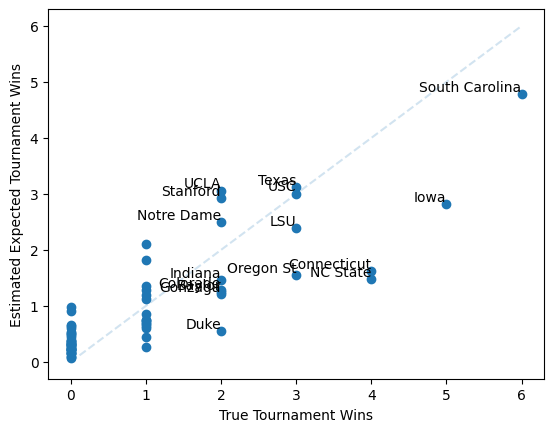

In [52]:
fig, ax = plt.subplots()
ax.scatter(Xy_OLRE_W_2024['Tournament Wins'], W_expected_tournament_wins['Expected Tournament Wins'])
ax.plot([0, 6], [0, 6], linestyle='--', alpha=0.2)
for i, (x, y) in enumerate(zip(Xy_OLRE_W_2024['Tournament Wins'], W_expected_tournament_wins['Expected Tournament Wins'])):
    if x > 1:
        plt.text(x, y, Xy_OLRE_W_2024.at[i, 'TeamName'], fontsize=10, ha='right', va='bottom')

ax.set_xlabel("True Tournament Wins")
ax.set_ylabel("Estimated Expected Tournament Wins")
fig.savefig("./images/2024-W-expected-tournament-wins-scatter.png", dpi=300)

# Evaluation

In [53]:
def evaluate_2025(pred_file):
    score = 0
    result_df = pd.read_csv("2025-tournament-results.csv")
    pred_df = pd.read_csv(pred_file)
    print(pred_df[pred_df["ID"] == "2025_1181_1222"])
    for i in range(result_df.shape[0]):
        ID = result_df.iloc[i]["ID"]
        result = result_df.iloc[i]["result"]
        pred = pred_df[pred_df["ID"] == ID]["pred"].item()
        score = score + (pred - result) ** 2

    print(result_df.shape[0])
    print(score / result_df.shape[0])

In [63]:
evaluate_2025("./prediction/2025-logistic-regression-prediction.csv")
evaluate_2025("./prediction/2025-manual-overwrite-logistic-regression-prediction.csv")

                   ID      pred
24199  2025_1181_1222  0.433185
124
0.11393354179646896
                   ID      pred
24199  2025_1181_1222  0.349808
124
0.12685882512878902


In [55]:
evaluate_2025("2025-manual-overwrite-logistic-regression-prediction.csv")

                   ID      pred
24199  2025_1181_1222  0.491779
124
0.11769501568442639


In [89]:
def evaluate_2025_with_seed_based_predictor():
    score = 0
    upsets_M, upsets_W = 0, 0
    result_df = pd.read_csv("2025-tournament-results.csv")
    for i in range(result_df.shape[0]):
        result = result_df.iloc[i]["result"]
        teamID_0 = int(result_df.iloc[i]["ID"][5:9])
        teamID_1 = int(result_df.iloc[i]["ID"][10:14])
        seed_0, seed_1 = None, None
        if teamID_0 < 3000:
            seed_0 = ncaa_tourney_seeds["M"][lambda df: (df["Season"] == 2025) & (df["TeamID"] == teamID_0)]["Seed"].item()
            seed_1 = ncaa_tourney_seeds["M"][lambda df: (df["Season"] == 2025) & (df["TeamID"] == teamID_1)]["Seed"].item()
        else:
            seed_0 = ncaa_tourney_seeds["W"][lambda df: (df["Season"] == 2025) & (df["TeamID"] == teamID_0)]["Seed"].item()
            seed_1 = ncaa_tourney_seeds["W"][lambda df: (df["Season"] == 2025) & (df["TeamID"] == teamID_1)]["Seed"].item()
        seed_0, seed_1 = int(seed_0[1:3]), int(seed_1[1:3])
        pred = 1 if seed_0 < seed_1 else (0 if seed_0 > seed_1 else 0.5)
        print(pred, result)
        if pred != 0.5 and np.abs(seed_0 - seed_1) >= 5:
            if pred != result:
                if teamID_0 < 3000:
                    upsets_M += 1
                else:
                    upsets_W += 1
        score += (pred - result) ** 2

    print(f"Mens upsets: {upsets_M}")
    print(f"Womens upsets: {upsets_W}")
    print(score / result_df.shape[0])

In [90]:
evaluate_2025_with_seed_based_predictor()

1 1
1 1
1 1
0 0
1 1
0 1
0 1
0 0
1 1
1 1
1 1
0 1
1 1
0 1
0 1
1 1
0 1
0 1
0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
1 0
0 1
1 1
0 0
1 1
1 1
1 0
1 1
1 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
0 1
1 1
1 1
1 1
1 1
0 0
0 1
1 1
0 0
0 1
1 1
1 1
0 0
0 1
1 1
0 0
1 1
0 0
0 0
0 0
1 0
1 0
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
0 0
0 1
0 0
1 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0.5 0
0.5 0
0 1
0.5 1
Mens upsets: 4
Womens upsets: 0
0.17540322580645162
